# Interactive Demo, Nested Sampling

This is a version of the demo that is intended to show basic operation of `prospector` including nested sampling with `dynesty`. It runs over the same model and code in the `demo_mock_params.py` parameter file, where we generate a mock broadband SED and then fit it.

First let's set up some environmental dependencies. These just make the numerics easier and adjust some of the plotting defaults to make things more legible.

In [1]:
import time, sys, os
import h5py
import numpy as np
from matplotlib.pyplot import *

%matplotlib inline

# re-defining plotting defaults
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})

**Prospector** utilizes three main packages:
- **fsps**, which governs the fundamental stellar population synthesis models (via the **python-fsps** package),
- **sedpy**, which contains some routines for computing projecting spectra onto filter bandpasses, and
- **prospect**, which is where the likelihood evaluations, parameter priors, and posterior sampling takes place.

Let's import those now.

In [2]:
import fsps
import sedpy
import prospect

We are going to use `dynesty` for nested sampling and write the results to an HDF5 file, so let's make sure those are installed

In [3]:
import h5py
import dynesty

# The parameter file

We need several things to run a fit.  These include 
  1. A `model` object (to store and translate parameters and priors of our model)
  2. A stellar population synthesis object (to predict spectra from parameters)
  3. An `obs` dictionary (with the data we intend to fit)
  
It can also useful to collect the meta-parameters contolling how the fit is done in a ``run_params`` dictionary. We will do that as we go along.  We will also encapsulate each step of the setup in a series of `load_()` functions.  Normally these would be written in your *parameter file*

## The model object

We need a set of model parameters, which will **define** the model we are tying to fit to the data.  The model object stores the parameters that are used by the SPS object to build a spectrum, as well as infomation about which parameters are to be varied during fitting, and priors on those parameters.  It efficiently converts between a vector of parameter values (the `theta` attribute) used by the MCMC samplers or optimizers and the dictionary of parameter names and values (the `params` attribute) that can be passed to the sps objects' `get_spectrum()` method.

To create the model object we need a list or dictionary of model parameters and some infomation about them.  Each parameter must a have a name, a length (vector parameters are possible), an initial value, and must be specified as either a free parameter or a fixed parameter.  If it is a free parameter it needs a prior as well, which we will get from the `priors` module.

We will start with a set of prepackaged parameters from the `prospect.models.templates` module and modify that as necessary for our model. First, lets look at what pre-packaged parameter sets are available.

In [4]:
from prospect.models.templates import TemplateLibrary
# Look at all the prepackaged parameter sets
TemplateLibrary.show_contents()

'agn':
  The set of (fixed) AGN dusty torus emission parameters.
'burst':
  The set of (fixed) SFR burst parameters, with the burst time controlled by `fage_burst`.
'ssp':
  Basic set of (free) parameters for single burst SFH
'nonparametric':
  Non-parameteric SFH with Dirichlet prior
'nebular':
  The set of nebular emission parameters, with gas_logz tied to stellar logzsol.
'dust_emission':
  The set of (fixed) dust emission parameters.
'alpha':
  The prospector-alpha model, Leja et al. 2017
'parametric':
  Basic set of (free) parameters for a delay-tau SFH.


It looks like the `"parametric"` set will do most of what we want.  Let's look at it in more detail.

In [5]:
TemplateLibrary.describe("parametric")

Free Parameters: (name: prior) 
-----------
  logzsol: <class 'prospect.models.priors.TopHat'>(mini=-2,maxi=0.19)
  dust2: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=2.0)
  tau: <class 'prospect.models.priors.LogUniform'>(mini=0.1,maxi=30)
  tage: <class 'prospect.models.priors.TopHat'>(mini=0.001,maxi=13.8)
  mass: <class 'prospect.models.priors.LogUniform'>(mini=100000000.0,maxi=1e+12)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  zred: 0.1 
  sfh: 4 


That looks pretty good. It has 5 free parameters:
- stellar mass *formed* $M_\star$,
- metallicity $\log Z/Z_\odot$, 
- age $t$ of the galaxy 
- star formation timescale $\tau$ for an exponentially declining star formation history (SFH), and
- dust attenuation of old stellar populations $A_V$.

The other two parameters are fixed explicitly.  Detailed description of most of the parameters can be found in the python-FSPS or FSPS documentation. There are many other `sps` parameters that are set implicitly in the python-FSPS defaults, but they can easily be added as prospector parameters and their values changed.  

Note that by default the stellar mass here refers to the stellar mass *formed* by the given age, which will always be slightly higher than the *surviving* stellar mass, due to mass loss during stellar evolution (winds, SNe, etc.)

We'll use the "parametric" set and adjust a couple of the priors, add a few (fixed) parameters, and we should be done. We do all this within a `load_model` method for flexibility.

In [6]:
def load_model(zred=0.1, fixed_metallicity=None, add_neb=False, 
               **extras):
    """Instantiate and return a ProspectorParams model subclass.
    
    :param zred: (optional, default: 0.1)
        The (fixed) redshift of the model
        
    :param fixed_metallicity: (optional)
        If provided, fix the metallicity (log(Z/Z_\sun)) to this value.  
        Otherwise the metallicty is a free parameter.
        
    :param add_neb: (optional, default: False)
        If True, turn on nebular emission and add relevant parameters to the model
    """
    from prospect.models import priors, SedModel
    from prospect.models.templates import TemplateLibrary

    model_params = TemplateLibrary["parametric"]
        
    # Adjust priors
    model_params["logzsol"]["prior"] = priors.TopHat(mini=-1.0, maxi=0.1)
    model_params["tau"]["prior"] = priors.LogUniform(mini=1e-1, maxi=1e1)
    model_params["mass"]["prior"] = priors.LogUniform(mini=1e9, maxi=1e11)
    model_params["tage"]["prior"] = priors.TopHat(mini=1, maxi=13.6)
    
    # Add burst parameters (fixed to zero be default)
    model_params.update(TemplateLibrary["burst"])
    # Add dust emission parameters (fixed)
    model_params.update(TemplateLibrary["dust_emission"])
 
    # Add nebular emission parameters and turn nebular emission on
    if add_neb:
        model_params.update(TemplateLibrary["nebular"])
    
    if fixed_metallicity is not None:
        # make it a fixed parameter
        model_params["logzsol"]["isfree"] = False
        #And use value supplied by fixed_metallicity keyword
        model_params["logzsol"]['init'] = fixed_metallicity 

    if zred is not None:
        # make sure zred is fixed
        model_params["zred"]['isfree'] = False
        # And set the value to the object_redshift keyword
        model_params["zred"]['init'] = zred

    # Now instantiate the model using this new dictionary of parameter specifications
    model = SedModel(model_params)

    return model

There are several 'meta' parameters that control the operation of this function.  Let's save them to a `run_params` dictionary.

In [7]:
run_params = {}
run_params["zred"] = 0.1
run_params["fixed_metallicity"] = None
run_params["add_neb"] = False

## The `sps` object
We need an object that will build SEDs for a given set of model parameters.  In `prospector` we call these **sps** objects.  Given a dictionary of parameters (provided by the model object), they must be able to return a spectrum, photometry, and maybe some ancillary information.  This is often done using large spectral libraries and, for galaxies, isochrone information.  This object often has a large memory footprint.

Usually you will not need to interact with this object directly, but you do need to choose one that can generate a spectrum for the kind of model you have. Typically in `prospector` we use `fsps.StellarPopulation` objects, under thin wrappers that add a little functionality and change the API a bit. The different wrappers correspond to different SFH parameterizations. Here we use `CSPSpecBasis` which works with (linear combinations of) composite stellar populations as described in the FSPS manual with `sfh_type` of 1, 4, or 5.  Other `sps` objects can be used for non-parameteric SFH, notably `prospect.sources.FastStepBasis`.

Again, it can be helpful to encapsulate the loading of the sps object in a `load_sps` method, with meta-parameters controlling the how the object is instantiated

In [8]:
def load_sps(zcontinuous=1, **extras):
    """Instantiate and return the Stellar Population Synthesis object.

    :param zcontinuous: (default: 1)
        python-fsps parameter controlling how metallicity interpolation of the 
        SSPs is acheived.  A value of `1` is recommended.
        * 0: use discrete indices (controlled by parameter "zmet")
        * 1: linearly interpolate in log Z/Z_\sun to the target 
             metallicity (the parameter "logzsol".)
        * 2: convolve with a metallicity distribution function at each age.  
             The MDF is controlled by the parameter "pmetals"
    """
    from prospect.sources import CSPSpecBasis
    sps = CSPSpecBasis(zcontinuous=zcontinuous)
    return sps

run_params["zcontinuous"] = 1

## The data to be fit

Now we are ready to fit some data, real or mock. The data to be fit is stored in a dictionary that we will call `obs`. The `obs` dictionary stores the observed fluxes, uncertainties, and information about how those fluxes were measured.

For spectra this means the wavelengths at which the fluxes were measured, while for photometry we must know the filters through which the fluxes were measured.
This information is passed (via the `obs` dictionary) to the model object to specify which data to predict.

The units of the fluxes and uncertainties in this dictionary are assumed to be maggies (i.e Jy/3631). The wavelength units are assumed to be observed frame vacuum angstroms.

We will create an `obs` dictionary below, with all of the required keys, starting with photometry.  This will be created from a mick, which is to say we will generate a model SED at a particular set of parameters and add noise to it, and use that as the 'data'.

In [9]:
def load_obs(snr=10.0, add_noise=True, filterset=["sdss_g0", "sdss_r0"],
             **kwargs):
    """Make a mock dataset.  Feel free to add more complicated kwargs, and put
    other things in the run_params dictionary to control how the mock is
    generated.

    :param snr:
        The S/N of the phock photometry.  This can also be a vector of same
        lngth as the number of filters.

    :param add_noise: (optional, boolean, default: True)
        If True, add a realization of the noise to the mock spectrum
        
    :param filterset:
        A list of `sedpy` filter names.  Mock photometry will be generated 
        for these filters.
    """
    # We'll put the mock data in this dictionary, just as we would for real
    # data.  But we need to know which bands (and wavelengths if doing
    # spectroscopy) in which to generate mock data.
    mock = {}
    mock['wavelength'] = None # No spectrum
    # Here we instantiate the `Filter()` objects using methods in `sedpy`, 
    # and put the resulting list of Filter object in the "filters" key 
    # of the obs dictionary.  These are used to convert a model spectrum 
    # into broadband fluxes.
    from sedpy.observate import load_filters
    mock['filters'] = load_filters(filterset)
    mock["phot_wave"] = [f.wave_effective for f in mock["filters"]]

    # We need the models to make a mock
    sps = load_sps(**kwargs)
    model = load_model(**kwargs)

    # Now we get any mock params from the kwargs dict,
    # and set them in the model
    params = {}
    for p in model.params.keys():
        if p in kwargs:
            params[p] = np.atleast_1d(kwargs[p])

    # And build the mock SED
    model.params.update(params)
    spec, phot, mfrac = model.mean_model(model.theta, mock, sps=sps)

    # Now store some output
    mock['true_spectrum'] = spec.copy()
    mock['true_maggies'] = phot.copy()
    from copy import deepcopy
    mock['mock_params'] = deepcopy(model.params)
    # And add noise
    pnoise_sigma = phot / snr
    if add_noise:
        pnoise = np.random.normal(0, 1, len(phot)) * pnoise_sigma
        mock['maggies'] = phot + pnoise
    else:
        mock['maggies'] = phot.copy()
    mock['maggies_unc'] = pnoise_sigma
    mock['mock_snr'] = snr
    mock['phot_mask'] = np.ones(len(phot), dtype=bool)

    # No spectrum
    mock['wavelength'] = None
    mock["spectrum"] = None
    
    return mock


In [10]:
galex = ['galex_FUV', 'galex_NUV']
sdss = ['sdss_{0}0'.format(b) for b in ['u','g','r','i','z']]
twomass = ['twomass_{}'.format(b) for b in ['J', 'H', 'Ks']]
spitzer = ['spitzer_irac_ch'+n for n in ['1','2','3','4']]

# Mock data parameters
run_params['snr']= 20.0
run_params['add_noise'] = False
run_params['filterset'] = galex + sdss + twomass + spitzer[:2]
# Input parameters for the mock spectrum
run_params['mass'] = 1e10
run_params['logzsol'] = -0.5
run_params['tage'] = 12.
run_params['tau'] = 3.
run_params['dust2'] = 0.3
run_params['zred'] = 0.1
run_params['add_neb'] = False


# Fitting

The code above is all stuff that gets defined by you the user in your *parameter file*. Now we are going to run through the steps that are done automatically in the `prospector_dynesty.py` script, with some stops along the way to explain what is happening.

## Instantiate Ingredients
First let us call the `load` functions that we defined earlier, passing to them the 'meta' parameters stored in the `run_params` dictionary.

In [11]:
print("Run parameters:")
for k, v in run_params.items():
    print("  {} = {}".format(k, v))
model = load_model(**run_params)
sps = load_sps(**run_params)
obs = load_obs(**run_params)
print("\nFilters:\n  {}".format(obs["filters"]))
print("\nFree Parameters:\n  {}".format(model.free_params))

Run parameters:
  logzsol = -0.5
  dust2 = 0.3
  tage = 12.0
  tau = 3.0
  fixed_metallicity = None
  zred = 0.1
  add_neb = False
  zcontinuous = 1
  snr = 20.0
  add_noise = False
  mass = 10000000000.0
  filterset = ['galex_FUV', 'galex_NUV', 'sdss_u0', 'sdss_g0', 'sdss_r0', 'sdss_i0', 'sdss_z0', 'twomass_J', 'twomass_H', 'twomass_Ks', 'spitzer_irac_ch1', 'spitzer_irac_ch2']

Filters:
  [<class 'sedpy.observate.Filter'>(galex_FUV), <class 'sedpy.observate.Filter'>(galex_NUV), <class 'sedpy.observate.Filter'>(sdss_u0), <class 'sedpy.observate.Filter'>(sdss_g0), <class 'sedpy.observate.Filter'>(sdss_r0), <class 'sedpy.observate.Filter'>(sdss_i0), <class 'sedpy.observate.Filter'>(sdss_z0), <class 'sedpy.observate.Filter'>(twomass_J), <class 'sedpy.observate.Filter'>(twomass_H), <class 'sedpy.observate.Filter'>(twomass_Ks), <class 'sedpy.observate.Filter'>(spitzer_irac_ch1), <class 'sedpy.observate.Filter'>(spitzer_irac_ch2)]

Free Parameters:
  ['logzsol', 'dust2', 'tau', 'tage', 'mass

## View the mock and model
Now that we have all the ingredients we can look at the mock data and generate a model SED.  Let's do that!

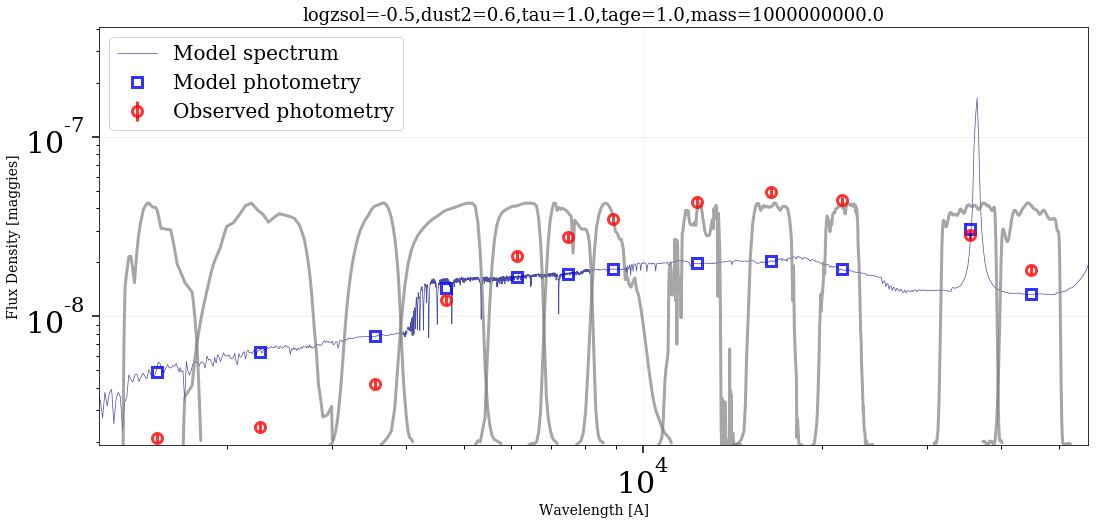

In [12]:
# Generate the model SED at some value of theta
theta = model.theta.copy()
theta[model.theta_index["mass"]] = 1e9
initial_spec, initial_phot, initial_mfrac = model.sed(theta, obs=obs, sps=sps)
# spec, phot, x = sps.get_spectrum(outwave=obs['wavelength'], filters=obs["filters"], **model.params)
title_text = ','.join(["{}={}".format(p, model.params[p][0]) for p in model.free_params])

a = 1.0 + model.params.get('zred', 0.0) # cosmological redshifting
# photometric effective wavelengths
wphot = obs["phot_wave"]
# spectroscopic wavelengths
if obs["wavelength"] is None:
    # *restframe* spectral wavelengths, since obs["wavelength"] is None
    wspec = sps.wavelengths.copy()
    wspec *= a #redshift them
else:
    wspec = obs["wavelength"]

# establish bounds
xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
temp = np.interp(np.linspace(xmin,xmax,10000), wspec, initial_spec)
ymin, ymax = temp.min()*0.8, temp.max()/0.4
figure(figsize=(16,8))

# plot model + data
loglog(wspec, initial_spec, label='Model spectrum', 
       lw=0.7, color='navy', alpha=0.7)
errorbar(wphot, initial_phot, label='Model photometry', 
         marker='s',markersize=10, alpha=0.8, ls='', lw=3,
         markerfacecolor='none', markeredgecolor='blue', 
         markeredgewidth=3)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], 
         label='Observed photometry',
         marker='o', markersize=10, alpha=0.8, ls='', lw=3,
         ecolor='red', markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)
title(title_text)

# plot Filters
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t /= t.max()
    t = 0.1*(ymax-ymin)*t + ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)

# prettify
xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()


Note that creating a new model with FSPS is somewhat time-intensive (of order seconds), but once the relevant SSPs have been built they are subsequently stored in cache so similar models can be generated much more quickly (of order milliseconds, unless you are changing parameters that affect the SSPs, like the IMF)

## Likelihood function
Now all we are missing is a likelihood function.  In most cases, this will simply be a function of the **spectral likelihood** and a **photometric likelihood** such that

$$
\mathcal{L} = f(\mathcal{L}_{\textrm{spec}}, \mathcal{L}_{\textrm{phot}}) \quad .
$$

Assuming our errors are Normal (i.e. Gaussian), the log-likelihoods for each component are extremely straightforward to define and can be imported directly from Prospector.  How we choose to combine these likelihoods might vary depending on the particulars of our data. For the demo, our likelihood function for our model parameters $\boldsymbol{\theta}$ is just

$$
\ln\mathcal{L}(\boldsymbol{\theta}) = \ln\mathcal{L}_{\textrm{spec}}(\boldsymbol{\theta}) + \ln\mathcal{L}_{\textrm{phot}}(\boldsymbol{\theta}) \quad .
$$

Below is a simple version of the likelihood function used in `prospector`.  Note that more complicated likelihoods including covariant noise and fitted noise parameters are possible, using special NoiseModel classes within `prospector`.  Also we are using the globally defined `obs`, `model`, and `sps`; in principle these could be passed as arguments to the `lnprobfn`.

For nested sampling `lnprobfn(theta, nested=True)` will return the likelihood (since the prior probability is accounted for by drawing proposals from the priors), while for other types of MCMC sampling `lnprobfn(theta, nested=False)` returns the posterior probability.

When using the provided scripts (`prospector.py` and `prospector_nest.py`) you don't have to specify the likelihood function yourself, it is defined in those scripts.

In [13]:
from prospect.likelihood import lnlike_spec, lnlike_phot, write_log

nested = True
verbose = False
def lnprobfn(theta, nested=False, verbose=verbose):
    """
    Given a parameter vector, a dictionary of observational data 
    a model object, and an sps object, return the ln of the posterior. 
    This requires that an sps object (and if using spectra 
    and gaussian processes, a GP object) be instantiated.
    """

    # Calculate prior probability and return -inf if not within prior
    # Also if doing nested sampling, do not include the basic priors, 
    # since the drawing method already includes the prior probability
    lnp_prior = model.prior_product(theta, nested=nested)
    if not np.isfinite(lnp_prior):
        return -np.infty
        
    # Generate "mean" model
    t1 = time.time()
    spec, phot, mfrac = model.mean_model(theta, obs, sps=sps)
    d1 = time.time() - t1
 
    # Calculate likelihoods
    t2 = time.time()
    lnp_spec = lnlike_spec(spec, obs=obs)
    lnp_phot = lnlike_phot(phot, obs=obs)
    d2 = time.time() - t2
    if verbose:
        write_log(theta, lnp_prior, lnp_spec, lnp_phot, d1, d2)

    return lnp_prior + lnp_phot + lnp_spec

run_params["verbose"] = verbose

For nested sampling, we also need a prior transform function.  If we've used the priors from the `prospect.models.priors` modules then this is easy to do.

In [14]:
def prior_transform(u):        
    return model.prior_transform(u)

## Sampling the Posterior
Now we can begin sampling from the posterior using **Monte Carlo** (MC) techniques. Prospector can use either ensemble MCMC with Dan Foreman-Mackey's **emcee** or nested sampling with Josh Speagle's **dynesty**. In this interactive notebook though we will use `dynesty`.

The `dynesty` algorithm requires several options to be specified, related to the number of live points, the way it zeros in on regions of high posterior mass, and the stopping criteria.  These can be adjusted to tradeoff speed and accuracy in the posterior and evidence estimation. For convenience we will store these in the same `run_params` meta-parameter dictionary that we've been using.

In [15]:
# dynesty Fitter parameters
dyn_params = {'nested_bound': 'multi', # bounding method
              'nested_sample': 'unif', # sampling method
              'nested_nlive_init': 100,
              'nested_nlive_batch': 100,
              'nested_bootstrap': 0,
              'nested_dlogz_init': 0.05,
              'nested_weight_kwargs': {"pfrac": 1.0},
              'nested_stop_kwargs': {"post_thresh": 0.1}
              }
run_params.update(dyn_params)


Let's go ahead and start sampling!  Relax because this might take 20 minutes.

In [16]:
# suppress output
#fout = sys.stdout
#fnull = open(os.devnull, 'w')
#sys.stdout = fnull

# Get some useful functions
from prospect import fitting
from dynesty.dynamicsampler import stopping_function, weight_function

# Start sampling
import time
tstart = time.time()  # time it
out = fitting.run_dynesty_sampler(lnprobfn, prior_transform, model.ndim,
                                  stop_function=stopping_function,
                                  wt_function=weight_function,
                                  **run_params)
duration = time.time() - tstart

#sys.stdout = fout
print('done sampling in {0}s'.format(duration))

iter: 2264 | batch: 1 | nc: 44 | ncall: 132770 | eff(%):  1.714 | loglstar: 207.158 < 210.602 < 209.058 | logz: 196.243 +/-  0.350 | stop:  1.079    

done sampling in 1164.82902598s


## Write Output
Now that everything's all set, let's save our results to disk.  These will be written to one or more files beginning with the value of `run_params["outfile"]`.

In [17]:
from prospect.io import write_results
run_params["outfile"] = "demo_nested"
outroot = "{0}_{1}".format(run_params['outfile'], int(time.time()))
hfile = outroot + '_mcmc.h5'
print("Writing to {}".format(hfile))
write_results.write_hdf5(hfile, run_params, model, obs, out, None, 
                         tsample=duration)

# The code below can be used to write python pickles (like IDL save files) to disk.  
# These are not necessary, but can be convenient.
#        partext = write_results.paramfile_string(**run_params)
#        write_results.write_model_pickle(outroot + '_model', model, powell=None,
#                                         paramfile_text=partext)

print('Finished')

Writing to demo_nested_1523206024_mcmc.h5
Could not serialize model_params
Could not JSON serialize mock_params, pickled instead
Finished


# Visualizing the Results

There are a few basic plotting tools available to do a quick check on the results available in *prospect.io.read_results* and *prospect.utils.plotting*. We'll hack a few of these together in *plot_utils* here in the demo folder to make them a bit more amenable to plotting in this notebook.  We'll also import some functions useful for reading the output files we made.

In [18]:
from prospect.io.read_results import results_from, get_sps
from prospect.io.read_results import traceplot, subcorner
print(outroot) # This is the start of the filename where we saved the results

demo_nested_1523206024


## Reading output files
Reading our results from our Pickle or HDF5 file is straightforward using the `results_from` method.  This returns a "results" dictionary, the `obs` dictionary of data to which the model was fit, and the `SedModel` object that was used in the fitting.

In [19]:
# grab results (dictionary), the obs dictionary, and our corresponding models
res, obs, mod = results_from("{}_mcmc.h5".format(outroot), dangerous=False)
# Because we did not use a param file, we have to reload the model by hand
mod = load_model(**res["run_params"])
# let's look at what's stored in the `res` dictionary
print(res.keys())

[u'logvol', u'theta_labels', u'niter', u'model_params', u'samples_id', u'logz', u'ncall', u'efficiency', u'lnprobability', 'model', u'information', u'prospector_version', u'chain', u'lnlikelihood', u'optimizer_duration', u'sampling_duration', 'optimization_results', u'weights', u'run_params', u'logzerr', u'paramfile_text', 'obs']


Let's get the vector of input parameters:

In [20]:
theta_input = np.squeeze(np.array([obs["mock_params"][p] 
                                   for p in mod.theta_labels()]))
print("Mock parameters:", zip(mod.free_params, theta_input))

('Mock parameters:', [('logzsol', -0.5), ('dust2', 0.29999999999999999), ('tau', 3.0), ('tage', 12.0), ('mass', 10000000000.0)])


## Plotting parameter traces
To see how our MCMC samples look, we can examine a few traces (that is, the evolution of the parameter value with iteration in the MCMC chain.)

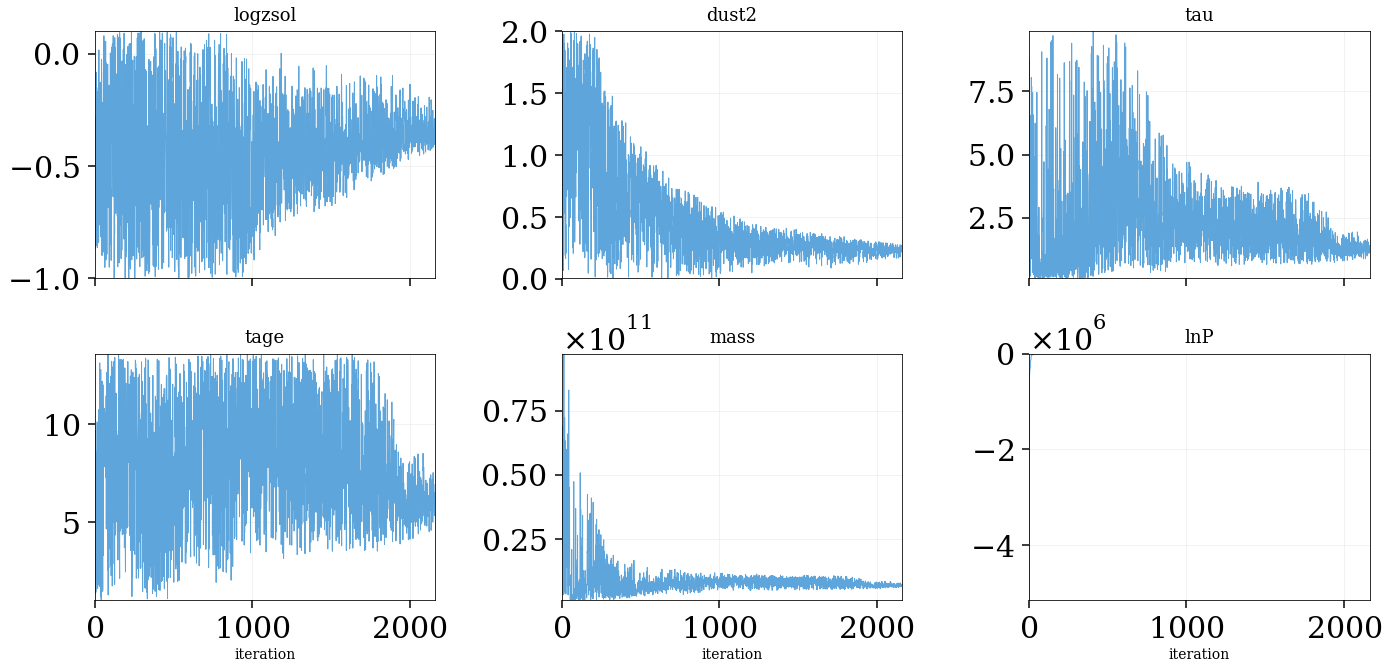

In [21]:
tracefig = traceplot(res, figsize=(20,10))

## Making a corner plot
Our samples more generally can be shown using a corner/triangle plot.  The `subcorner()` method below is a very thin wrapper on Dan Foreman-Mackey's **corner.py** code.  We'll overplot the input value as blue lines.  

MAP value: [ -2.05294994e-01   1.66836272e-01   8.83214882e-01   4.56968168e+00
   5.97259589e+09]


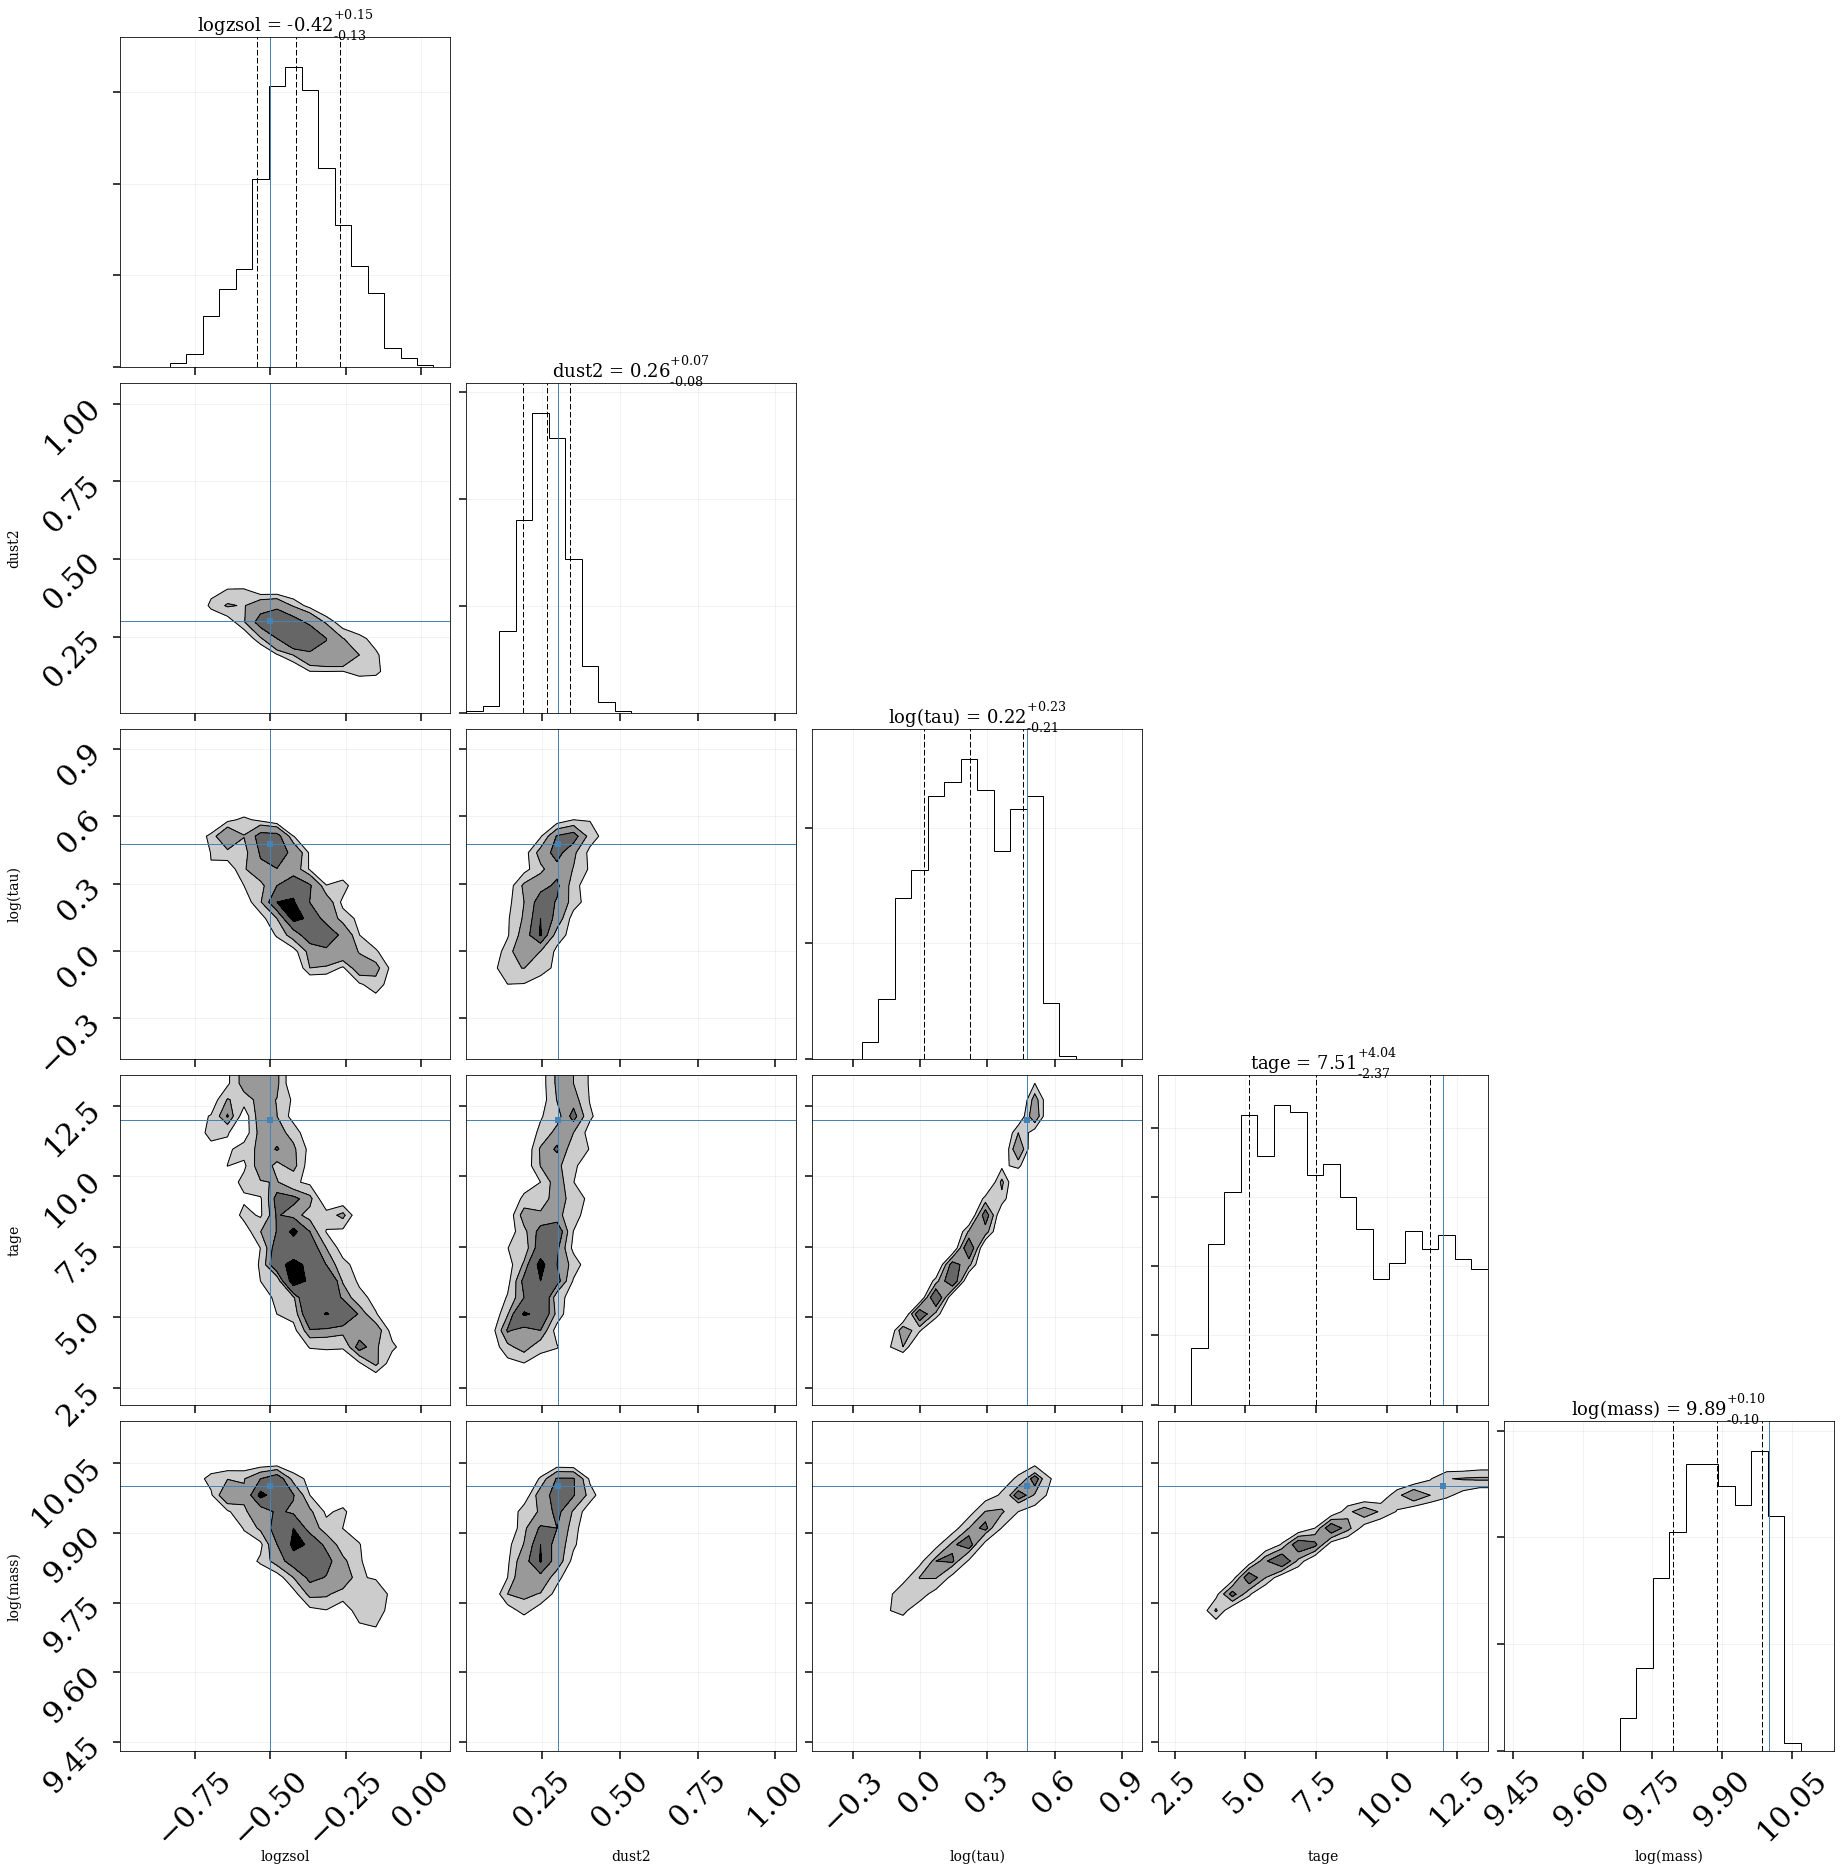

In [22]:
# maximum a posteriori (of the locations visited by the MCMC sampler)
imax = np.argmax(res['lnprobability'])
theta_max = res['chain'][imax, :].copy()
print('MAP value: {}'.format(theta_max))
# We throuw out the first 500 samples because they are (usually) very low probability 
# and can throw off the plotting algorithms
cornerfig = subcorner(res, start=500, thin=1, truths=theta_input,
                      fig=subplots(5,5,figsize=(27,27))[0])

## Look at SEDs and residuals
Finally, let's just take a look at a random model drawn from our chains, and at the highest posterior probability model in the chain.  In this notebook we already have the `sps` object instantiated, but in general we may have to regenerate it based on information stored in the output file using the `prospect.io.read_results.get_sps` method.

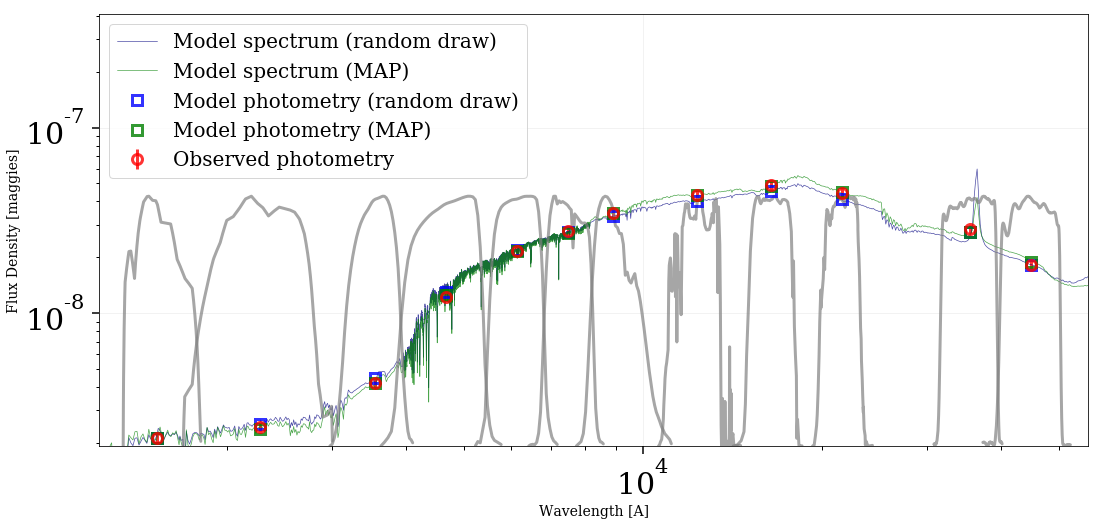

In [23]:
# Randomly chosen parameters from the chain. Note that we have to weight 
# our random choice by the nested sampling weights
sample_index = np.random.choice(len(res["chain"]), 
                                p=res["weights"])
theta = res['chain'][sample_index, :]

# generate models
# sps = get_sps(res)  # this works if using parameter files
sps = load_sps(**run_params)
mspec, mphot, mextra = mod.mean_model(theta, obs, sps=sps)
mspec_map, mphot_map, _ = mod.mean_model(theta_max, obs, sps=sps)
mspec_truth, mphot_truth, _ = mod.mean_model(theta_input, obs, sps=sps)


# wavelength vectors
a = 1.0 + model.params.get('zred', 0.0) # cosmological redshifting
# photometric effective wavelengths
wphot = obs["phot_wave"]
# spectroscopic wavelengths
if obs["wavelength"] is None:
    # *restframe* spectral wavelengths, since obs["wavelength"] is None
    wspec = sps.wavelengths.copy()
    wspec *= a #redshift them
else:
    wspec = obs["wavelength"]

# Make plot of data and model
figure(figsize=(16,8))

loglog(wspec, mspec, label='Model spectrum (random draw)',
       lw=0.7, color='navy', alpha=0.7)
loglog(wspec, mspec_map, label='Model spectrum (MAP)',
       lw=0.7, color='green', alpha=0.7)
#loglog(wspec, mspec_truth, label='Mock spectrum',
#       lw=0.7, color='green', alpha=0.7)
errorbar(wphot, mphot, label='Model photometry (random draw)',
         marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='blue', 
         markeredgewidth=3)
errorbar(wphot, mphot_map, label='Model photometry (MAP)',
         marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='green', 
         markeredgewidth=3)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], 
         label='Observed photometry', ecolor='red', 
         marker='o', markersize=10, ls='', lw=3, alpha=0.8, 
         markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)

# plot transmission curves
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t /= t.max()
    t = 0.1*(ymax-ymin)*t + ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)

xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()

In [24]:
print(lnprobfn(theta_input), mod.prior_product(theta_input))
print(lnprobfn(theta_max), mod.prior_product(theta_max))

(209.88334506426139, -30.500976644546071)
(210.57692657742422, -28.762774163996571)
